In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50

In [2]:
train_directory = 'Desktops/PLACES/seg_train/seg_train'
val_directory = 'Desktops/PLACES/seg_test/seg_test'
test_directory = 'DesktopS/PLACES/seg_pred'

In [3]:
image_size = (160,160)

In [4]:
data_aug = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255 , rotation_range=20,
                                                                width_shift_range=0.2,
                                                                height_shift_range=0.2,
                                                                horizontal_flip=True, validation_split=0.2)

In [5]:
train_dataset = data_aug.flow_from_directory(train_directory,
                                            subset = 'training',
                                            target_size = image_size,
                                            batch_size = 32 )
val_dataset = data_aug.flow_from_directory(val_directory,
                                         subset = 'validation',
                                         target_size = image_size,
                                          batch_size = 32)
test_dataset = data_aug.flow_from_directory(test_directory,
                                             target_size = image_size,
                                           batch_size = 32)
    

Found 11230 images belonging to 6 classes.
Found 598 images belonging to 6 classes.
Found 7301 images belonging to 1 classes.


In [6]:
image_shape = image_size + (3,)
mobilenet = tf.keras.applications.MobileNetV2(include_top = False,
                                             input_shape = image_shape,
                                             weights = 'imagenet')

In [7]:
mobilenet.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [12]:
model = Sequential()
model.add(mobilenet)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(1280, activation = 'relu'))
model.add(Dense(6, activation = 'softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_1 (Flatten)         (None, 1280)              0         
                                                                 
 dense_3 (Dense)             (None, 1280)              1639680   
                                                                 
 dense_4 (Dense)             (None, 6)                 7686      
                                                                 
Total params: 3,905,350
Trainable params: 1,647,366
No

In [13]:
model.compile(optimizer = 'Adam',
             loss = 'CategoricalCrossentropy',
             metrics = ['accuracy'])

In [14]:
mobilenet.trainable = False

In [15]:
model.fit(train_dataset,validation_data = val_dataset,epochs = 3)

Epoch 1/3
351/351 [==============================] - 402s 1s/step - loss: 0.9697 - accuracy: 0.7313 - val_loss: 0.6425 - val_accuracy: 0.7759
Epoch 2/3
351/351 [==============================] - 367s 1s/step - loss: 0.6038 - accuracy: 0.7848 - val_loss: 0.6988 - val_accuracy: 0.7341
Epoch 3/3
351/351 [==============================] - 375s 1s/step - loss: 0.5612 - accuracy: 0.7991 - val_loss: 0.6102 - val_accuracy: 0.7692


In [17]:
predictions = model.predict(test_dataset)

229/229 [==============================] - 435s 2s/step


In [18]:
import numpy as np
predicted_labels = np.argmax(predictions, axis=1)
print(predicted_labels)

[2 0 4 ... 4 5 1]


1/1 [==============================] - 2s 2s/step


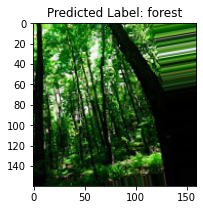

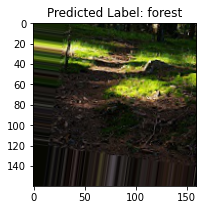

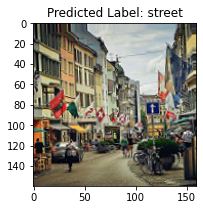

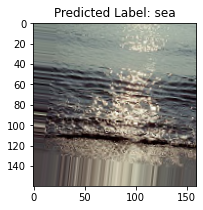

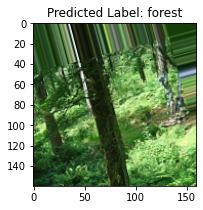

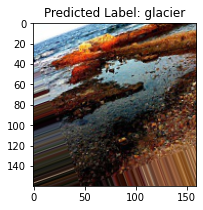

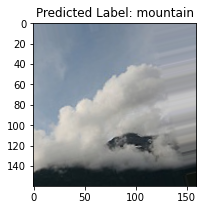

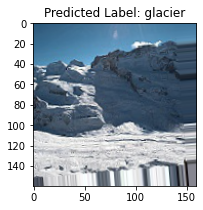

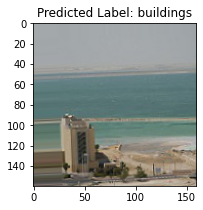

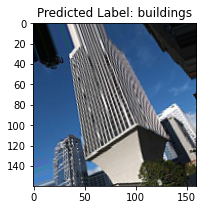

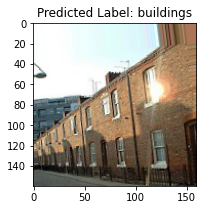

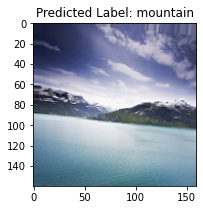

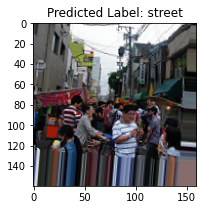

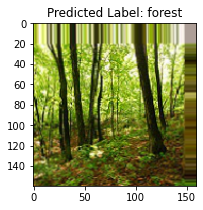

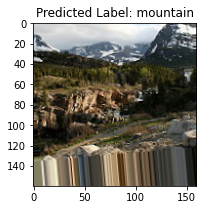

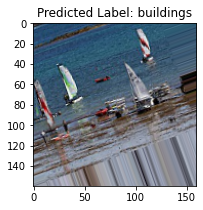

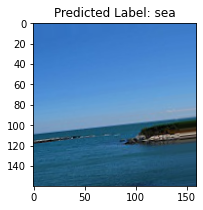

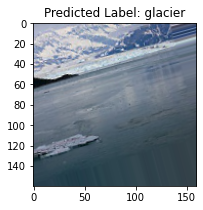

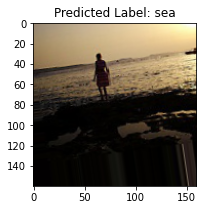

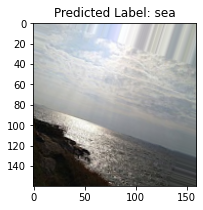

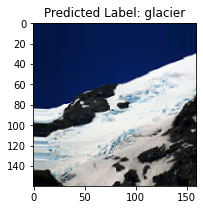

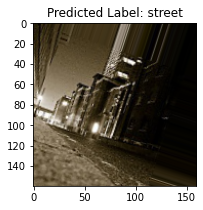

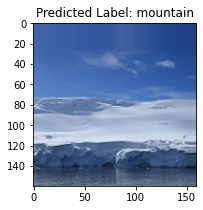

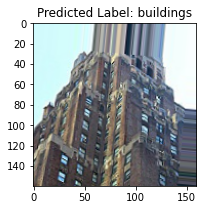

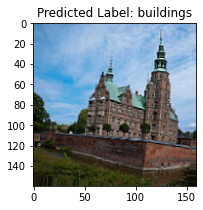

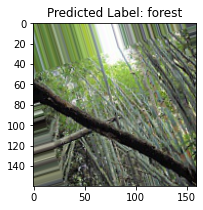

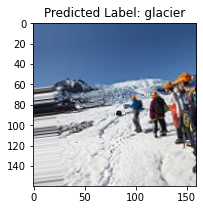

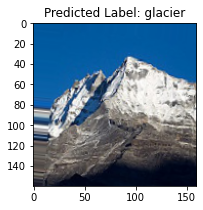

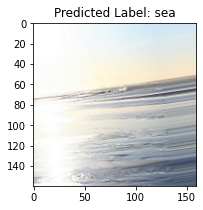

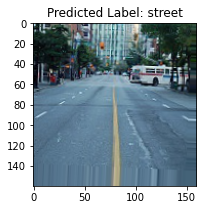

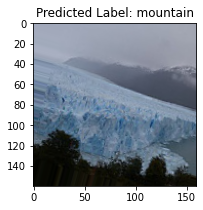

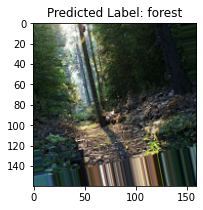

In [19]:
class_labels = ['buildings','forest','glacier','mountain','sea','street']  


for images, labels in test_dataset:
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    
    for i in range(min(100, len(images))):  
        plt.figure(figsize=(3, 3))
        plt.imshow(images[i])
        
        predicted_label = class_labels[predicted_labels[i]]
        
        plt.title(f"Predicted Label: {predicted_label}")
        plt.show()

    break  


In [20]:
mobilenet.trainable = True

In [22]:
for layer in mobilenet.layers[120:]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='CategoricalCrossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_1 (Flatten)         (None, 1280)              0         
                                                                 
 dense_3 (Dense)             (None, 1280)              1639680   
                                                                 
 dense_4 (Dense)             (None, 6)                 7686      
                                                                 
Total params: 3,905,350
Trainable params: 1,647,366
No

In [23]:
fine_tune_history = model.fit(
    train_dataset,
    epochs=2,
    validation_data=val_dataset
)

Epoch 1/2
351/351 [==============================] - 371s 1s/step - loss: 0.5029 - accuracy: 0.8235 - val_loss: 0.5387 - val_accuracy: 0.8027
Epoch 2/2
351/351 [==============================] - 442s 1s/step - loss: 0.5009 - accuracy: 0.8159 - val_loss: 0.5345 - val_accuracy: 0.7826
